## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
import string
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, roc_auc_score
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.model_selection import StratifiedKFold

from spellchecker import SpellChecker

import nltk
import gensim.downloader

In [8]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')

[nltk_data] Downloading package wordnet to C:\Users\Abhishek
[nltk_data]     Mehra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Abhishek
[nltk_data]     Mehra\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Abhishek
[nltk_data]     Mehra\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [9]:
RANDOM_STATE = 1

## Helper functions

####  Pre-training, removing na, ttsplit, traing and eval

#### Combined function for data cleaning

This includes:
1. Removing html
2. Removing URL
3. Lowercasing
4. Removing punctuations
5. Removing Stopwords
6. Separating Numbers and words joined together
7. Replacing number with tag
8. Lemmatization
9. Stemming

In [238]:
def data_cleaning(df):
    df2 = df.copy(deep = True)
    df2['cleaned_text'] = df2['text'].apply(lambda x:remove_html(x))
    df2['cleaned_text'] = df2['cleaned_text'].apply(lambda x: remove_url(x))
    df2['cleaned_text'] = lowercasing(df2['cleaned_text']) 
    df2['cleaned_text'] = df2['cleaned_text'].apply(lambda x: remove_punct(x))
    df2['cleaned_text'] = df2['cleaned_text'].apply(lambda x: remove_stopwords(x))
    df2['cleaned_text'] = df2['cleaned_text'].apply(lambda x:separate_num_word(x))
    df2['cleaned_text'] = df2['cleaned_text'].apply(lambda x: replace_number_with_tag(x))
    # df2['cleaned_text'] = df2['cleaned_text'].apply(lambda x:remove_nonenglish(x))
    df2['cleaned_text'] = df2['cleaned_text'].apply(lambda x:lemmatization(x))
    # df2['cleaned_text'] = df2['cleaned_text'].apply(lambda x:stemming_porter(x))
    
    return df2
    


#### Vectorization(count, tfidf)

In [273]:
def vectorization_df(vectorizer,df):

    train_counvec = vectorizer.fit_transform(df['cleaned_text'])
    train_df_vec = pd.DataFrame(train_counvec.todense(), columns = vectorizer.get_feature_names_out())
    print(train_counvec.shape)
    
    return train_df_vec


#### Pre-trained vectors apply

In [239]:
# word in tweet not existing in wv - ignore the word.
# all words in tweet not exsiting in wv - return np.nan
# empty string provided as tweet - return np.nan

#'dsdad dad'

def tweet_vec(tweet, pretrained_vec):
    tweet_word_vectors = []
    if not tweet:         #if tweet is ''
        return np.nan 
        
    tweet_words = tweet.split()
    
    for word in tweet_words:
        if word  in pretrained_vec:
            tweet_word_vectors.append(pretrained_vec[word])
            
        
    if not tweet_word_vectors:           #if tweet = 'asdas asdasdasd'
        return np.nan 
    
    
    return np.array(tweet_word_vectors)

#### Train test split

In [159]:
def ttsplit(df, label_col_name='target', feature_column=None, test_size=0.2):
    y = df[label_col_name]
    df = df.drop(label_col_name, axis=1, inplace=False)
    assert label_col_name not in df.columns

    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=test_size, shuffle=True, random_state=RANDOM_STATE, stratify=y)
    
    if feature_column:
        X_train = X_train[feature_column]
        X_test = X_test[feature_column]
        
    return X_train, X_test, y_train, y_test

#### Training and evaluation

In [11]:
def training_eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    output_dic = {'f1': round(f1_score(y_test, predictions), 3),
                  'precision': round(precision_score(y_test, predictions), 3),
                  'recall': round(recall_score(y_test, predictions), 3),
                  'classification': classification_report(y_test, predictions, output_dict=True)}
            

    print(f"F1 score is: {output_dic['f1']}, precision score is:{output_dic['precision']}, recall score is:{output_dic['recall']}")

#### Cross Validation

In [416]:
def cv_score_model(df, model, folds=5 ,feature_column=None ,label_col_name="target"):
    
   
    
    y = df[label_col_name].values  #dataframe to numpy array
    
    if feature_column:                    # this function will covert average vector to a single list of arrays, earlier it was list of multiple arrays
        x = df.drop(label_col_name, axis=1, inplace=False)   
        x = x[feature_column]
        x = np.vstack(x)
        
    else:
        x = df.drop(label_col_name, axis=1, inplace=False).values   #dataframe to numpy array
    
    skfold = StratifiedKFold(random_state=RANDOM_STATE, n_splits=folds, shuffle=True) #creating object of StratifiedKFold class 
    
    f1_score_c= []   #initialzing empty list to store f1 scores of cross validation folds
    roc_auc= []
    precision  = []
    recall = []
    
    fn = 0
    
    for train_i, test_i in skfold.split(x, y):   # skfold.split returns the indices
        X_train = x[train_i]
        y_train = y[train_i]
        
        X_test = x[test_i]
        y_test = y[test_i]
        
        model.fit(X_train, y_train)
        
        pred = model.predict(X_test)
        
        f1 = f1_score(y_test,pred)
        f1_score_c.append(f1)
        
        roc = roc_auc_score(y_test,pred)
        roc_auc.append(roc)
        
        prec = precision_score(y_test,pred)
        precision.append(prec)
        
        rec = recall_score(y_test,pred)
        recall.append(rec)
        fn += 1
        print("Done with fold: ", fn)
    
    
    print (f"precison_mean = {np.round(np.mean(precision),3)}, recall_mean= {np.round(np.mean(recall),3)}, f1_score_mean={np.round(np.mean(f1_score_c),3)},roc_mean= {np.round(np.mean(roc_auc),3)}")
        

#### Data cleaning functions

In [251]:
#### HTML removal

In [252]:
def remove_html(text):
    pattern = re.compile(r'<.*?>')
    return pattern.sub(r'',text)

In [253]:
#### URL removal

In [254]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',text)

In [255]:
#### Lowercasing

In [256]:
def lowercasing(text):
    return text.str.lower()
    

In [257]:
#### Punctuation removal

In [258]:
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

In [259]:
#### Stopwords removal

In [260]:
def remove_stopwords(text):
    d = ''
    for i in text.split():
        if i not in stop_words:
            d = d+ ' '+ i
    return d.strip() 

In [261]:
#### Replace number with a tag

In [262]:
def replace_number_with_tag(text):
    tag = '#'
    a = ''
    for i in text.split():  
        # print (i)
        if i.isdigit():
            a = a + ' ' + tag
        else:
            a = a + ' ' + i
        
    return a.strip()

In [263]:
#### Lemmatization

In [264]:
def lemmatization(text):
    combined = ''
    for word in text.split():
        # print (word)
        combined = combined + ' ' + lemmatizer.lemmatize(word)
        # print (combined)
        
    return combined.strip()
        

In [265]:
#### Stemming

In [266]:
def stemming_porter(text):
    combined = ''
    stemmer = PorterStemmer()
    for word in text.split():
        combined = combined + ' ' + stemmer.stem(word)
        
    return combined.strip()

In [267]:
#### Separating number and words together

In [268]:
def separate_num_word(text):
    new_text = ''
    for i in text.split():
        w = ''
        n = ''
        
        
        if  not i.isalpha():
            
            for c in i:
                if c.isdigit():
                    n = n+c
                else:
                    w = w+c
            
            new_text = new_text+ ' ' + n + ' ' + w
        
        else:
            new_text = new_text+ ' ' + i
            
    return new_text.strip()
        


## EDA

In [14]:
tweets_df = pd.read_csv('../data/train.csv')

In [15]:
# pd.options.display.max_colwidth=120

In [16]:
tweets_df.sample(10)

,id,keyword,location,text,target
6713,9613,thunderstorm,United States,OUN cancels Severe Thunderstorm Warning for Lincoln Logan Oklahoma [OK] http://t.co/bTi8JAMFiu #WX,1
2876,4133,drought,NaN,U.S. in record hurricane drought: The United States hasn't been hit by a major hurricane in the past nine years and ...,1
3153,4527,emergency,"Anchorage, AK",#Anchorage #Jobs Emergency Medicine - Nurse Practitioner - Healthcare Recruitment Counselors (Wasilla AK): Em... htt...,0
4333,6153,hijack,eating strawberry shitsickles,@mockingpanems @cuddlesforjen what if he slammed her against the wall for the wrong reason but then he came out of h...,0
4917,7002,mayhem,"Raleigh, NC",I liked a @YouTube video from @itsjustinstuart http://t.co/oDV3RqS8JU GUN RANGE MAYHEM!,1
396,571,arson,ÛÊÛÊÛÊ,Mariah getting thick in the shoulders poor girl.,1
3660,5210,fatalities,Ireland,Driver fatalities down on Irish roads but pedestrians and cyclists at more risk http://t.co/E7OJhpdfG2,1
6757,9681,tornado,Toronto,Environment Canada confirms 2nd tornado touched down last weekend åÈ http://t.co/x8zqbwNfO1,1
1528,2210,chemical%20emergency,"Littleton, CO, USA",THE CHEMICAL BROTHERS to play The Armory in SF tomorrow night!: EMERGENCY BAY AREA EDM ANNOUNCEMENT ÛÒ THE CHEM... ...,0
1987,2858,damage,U.S,#fitness Knee Damage Solution http://t.co/pUMbrNeBJE,0


In [17]:
tweets_df.shape

(7613, 5)

#### Distribution of target class


In [18]:
tweets_df.shape[0]

7613

In [19]:
tweets_df['target'].sum()/tweets_df.shape[0]

0.4296597924602653

In [20]:
(tweets_df['target']==0).sum()

4342

In [21]:
(tweets_df['target']==1).sum()

3271

C:\Users\Abhishek Mehra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

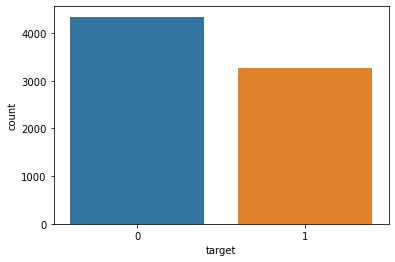

In [23]:
sns.countplot(tweets_df['target'])

#### frequency of stop words 

In [24]:
stop_words = set(stopwords.words('english'))

In [25]:
type(stop_words)

set

In [26]:
tweets_df['text'].str.split()

0                                           [Our, Deeds, are, the, Reason, of, this, #earthquake, May, ALLAH, Forgive, us, all]
1                                                                                [Forest, fire, near, La, Ronge, Sask., Canada]
2       [All, residents, asked, to, 'shelter, in, place', are, being, notified, by, officers., No, other, evacuation, or, sh...
3                                                     [13,000, people, receive, #wildfires, evacuation, orders, in, California]
4                      [Just, got, sent, this, photo, from, Ruby, #Alaska, as, smoke, from, #wildfires, pours, into, a, school]
                                                                 ...                                                           
7608                            [Two, giant, cranes, holding, a, bridge, collapse, into, nearby, homes, http://t.co/STfMbbZFB5]
7609    [@aria_ahrary, @TheTawniest, The, out, of, control, wild, fires, in, California, even, in, the, 

In [27]:
freq_stopwords = tweets_df['text'].str.split().apply(lambda x: len(set(x) & stop_words))

In [28]:
freq_stopwords.head()

0    5
1    0
2    7
3    1
4    5
Name: text, dtype: int64

In [29]:
freq_stopwords.sum()


25923

#### frequency of punctuations

In [30]:
punctuations = set(string.punctuation)

In [31]:
freq_punctuation = tweets_df['text'].str.split().apply(lambda x:len(set(x) & punctuations))

In [32]:
freq_punctuation.sum()

1080

## Data cleaning


#### Removing HTML

In [35]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(lambda x: remove_html(x))

In [36]:
tweets_df.sample(10)

,id,keyword,location,text,target,cleaned_text
1706,2462,collided,@protectingtitan's side.,--thus making @FemaleGilgamesh's assault useless.\nThe spears collided with the dark force however did not penetrate...,0,--thus making @FemaleGilgamesh's assault useless.\nThe spears collided with the dark force however did not penetrate...
7465,10681,wounds,"Paterson, New Jersey",Driver rams car into Israeli soldiers wounds 3: military: A driver rammed a car into a group of Israeli soldi... htt...,1,Driver rams car into Israeli soldiers wounds 3: military: A driver rammed a car into a group of Israeli soldi... htt...
6928,9937,trouble,?,When there's trouble you know who to caaaaaall,0,When there's trouble you know who to caaaaaall
5114,7294,nuclear%20disaster,NaN,Chernobyl disaster - Wikipedia the free encyclopedia don't you just love the nuclear technology it's so glorious ht...,1,Chernobyl disaster - Wikipedia the free encyclopedia don't you just love the nuclear technology it's so glorious ht...
3269,4694,engulfed,NaN,Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/fxdH3U8Bq3 http://t.co/...,1,Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/fxdH3U8Bq3 http://t.co/...
1716,2476,collided,"Cape Cod, Massachusetts USA",'Car vs motorcycle in Harwich Port' HARWICH PORT ÛÒ A car and motorcycle collided around 5:30 p.m. The crash happen...,1,'Car vs motorcycle in Harwich Port' HARWICH PORT ÛÒ A car and motorcycle collided around 5:30 p.m. The crash happen...
1408,2033,casualties,The Low-Cal Calzone Zone,I'M LAUGHING IN THE FACE OF CASUALTIES AND SORROW THE FIRST TIME I'M THINKING PAST TOMORROW BUT I AM NOT THROWIN AWA...,1,I'M LAUGHING IN THE FACE OF CASUALTIES AND SORROW THE FIRST TIME I'M THINKING PAST TOMORROW BUT I AM NOT THROWIN AWA...
5127,7312,nuclear%20reactor,NaN,@RobertHarding @RepJohnKatko Crazy to use the Netanyahu argument Iran can flush A NUCLEAR REACTOR DOWN THE TOILET,1,@RobertHarding @RepJohnKatko Crazy to use the Netanyahu argument Iran can flush A NUCLEAR REACTOR DOWN THE TOILET
2968,4264,drowning,New Jersey/ D.R.,@_jeesss_ @Ethereal_7 Hello 911 yeah we have someone drowning here send a medic http://t.co/7GiglwdMhy,1,@_jeesss_ @Ethereal_7 Hello 911 yeah we have someone drowning here send a medic http://t.co/7GiglwdMhy
1494,2154,catastrophe,NaN,Human history becomes more and more a race between education and catastrophe.,0,Human history becomes more and more a race between education and catastrophe.


#### Removing URLS

In [38]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(lambda x: remove_url(x) )

In [39]:
tweets_df.sample(10)

,id,keyword,location,text,target,cleaned_text
362,520,army,Pakistan,.: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: RT DrAyesha4: #IndiaKoMunTorJawabDo\n\nIndian Army ki...,0,.: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: RT DrAyesha4: #IndiaKoMunTorJawabDo\n\nIndian Army ki...
4768,6785,lightning,NaN,Yeah tonight I ride the lightning to my final resting place ??????,0,Yeah tonight I ride the lightning to my final resting place ??????
4920,7008,mayhem,GLOBAL/WORLDWIDE,@RaynbowAffair Editor In Chief @DiamondKesawn Releases Issue #7 http://t.co/7mzYcU2IHo of #RAmag. #Fashion #Models a...,0,@RaynbowAffair Editor In Chief @DiamondKesawn Releases Issue #7 of #RAmag. #Fashion #Models and #Mayhem
4601,6543,injury,"Sacramento, CA",Traffic Collision - No Injury: I5 S at I5 S 43rd Ave offramp South Sac http://t.co/cT9ejXoLpu,1,Traffic Collision - No Injury: I5 S at I5 S 43rd Ave offramp South Sac
1515,2189,catastrophic,"Paonia, Colorado",Learning from the Legacy of a Catastrophic Eruption http://t.co/PgXfocgHqg via @newyorker,1,Learning from the Legacy of a Catastrophic Eruption via @newyorker
2278,3266,demolish,Wema building,Enugu Government to demolish illegal structures at International Conference Centre http://t.co/7K5SHaiqIw,0,Enugu Government to demolish illegal structures at International Conference Centre
531,773,avalanche,NaN,GREAT PERFORMANCE CHIP FUEL/GAS SAVER CHEVY TAHOE/BLAZER/AVALANCHE/S-10 http://t.co/iCrZi5TqC5 http://t.co/ONxhKfHn2a,0,GREAT PERFORMANCE CHIP FUEL/GAS SAVER CHEVY TAHOE/BLAZER/AVALANCHE/S-10
3266,4691,engulfed,NaN,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad...,0,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad...
2371,3410,derail,"Los Angeles, CA",@BV Bloomberg will publish anything negative to try and derail public support in favor of the #IranDeal.,0,@BV Bloomberg will publish anything negative to try and derail public support in favor of the #IranDeal.
4611,6554,injury,NaN,Dante Exum's knee injury could stem Jazz's hoped-for surge back to ... http://t.co/8PIFutrB5U,1,Dante Exum's knee injury could stem Jazz's hoped-for surge back to ...


#### Lowercasing

In [41]:
tweets_df['cleaned_text'] = lowercasing(tweets_df['text']) 

In [42]:
tweets_df.head(5)

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this #earthquake may allah forgive us all
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...,1,all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place or...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive #wildfires evacuation orders in california"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school


#### Removing Punctuations

In [44]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(lambda x: remove_punct(x))

In [45]:
tweets_df.head(5)

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...,1,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place order...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,13000 people receive wildfires evacuation orders in California
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school


#### Removing stopwords

In [47]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(lambda x: remove_stopwords(x))

In [48]:
remove_stopwords('asdasd dadad')

'asdasd dadad'

In [49]:
tweets_df.head(5)

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds Reason #earthquake May ALLAH Forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...,1,All residents asked 'shelter place' notified officers. No evacuation shelter place orders expected
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive #wildfires evacuation orders California"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent photo Ruby #Alaska smoke #wildfires pours school


#### Replace numbers with number tag

In [51]:
replace_number_with_tag('43,2423 no 123 yes r24234')

'43,2423 no # yes r24234'

In [52]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(lambda x: replace_number_with_tag(x) )

In [53]:
tweets_df.sample(5)

,id,keyword,location,text,target,cleaned_text
186,265,ambulance,Happily Married with 2 kids,AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE CHOICE OF 14 LEZ COMPLIANT | eBay http://t.co/q8IVrzOJZv,0,AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE CHOICE OF # LEZ COMPLIANT | eBay http://t.co/q8IVrzOJZv
5677,8101,rescued,West Hollywood,Summer #summervibes #california #puppy #pitmix #rescued #brixton #banksy #happy #mybabies https://t.co/7VoVkTXsPo,0,Summer #summervibes #california #puppy #pitmix #rescued #brixton #banksy #happy #mybabies https://t.co/7VoVkTXsPo
2548,3656,destroy,Honduras,Black Ops 3 SEARCH AND DESTROY GAMEPLAY! (Hunted SnD Competitive Multiplayer): http://t.co/ss1zL36y9V via @YouTube,0,Black Ops # SEARCH AND DESTROY GAMEPLAY! (Hunted SnD Competitive Multiplayer): http://t.co/ss1zL36y9V via @YouTube
6261,8946,storm,NaN,So this storm just came out of no where. .fuck me its cool,1,So this storm just came out of no where. .fuck me its cool
6692,9589,thunder,NaN,I hear lightening and see thunder,1,I hear lightening and see thunder


#### spell correct ***

In [596]:
# spell = SpellChecker()

In [556]:
# def spell_correct(text):
#     combined = ''
    
        

In [ ]:
# tweets_df['cleaned_text'] = tweets_df['text'].apply(lambda x: spell_correct(x))

#### Removing non-english words

In [54]:
words = set(nltk.corpus.words.words())

In [55]:
def remove_nonenglish(text):
    combined = ''
    for word in text.split():
        if word in words or word == '#':
            combined = combined + ' ' + word
            
    return combined.strip()
            
            

In [56]:
remove_nonenglish('fire aaa hi not in  aaarr #')

'fire hi not in #'

In [57]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(lambda x:remove_nonenglish(x))

#### Lemmatization

*Lemmetization is grouping together inflected(different forms of words based on gender, verb, etc) forms of words. eg rocks,rock - rock., better : good*

In [58]:
lemmatizer = WordNetLemmatizer()

In [60]:
lemmatization('wolves dogs cats better studies cries crying')

'wolf dog cat better study cry cry'

In [61]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(lambda x:lemmatization(x))

In [62]:
tweets_df.sample(10)

,id,keyword,location,text,target,cleaned_text
2795,4021,disaster,NaN,#Metepec #Mexico - ?NIGHT DISASTER?...E(Oficial) @ #NitClub #mÌ¼sica #mÌ¼sica http://t.co/WTfJF9jjzs,1,#Metepec #Mexico - ?NIGHT DISASTER?...E(Oficial) @ #NitClub #mÌ¼sica #mÌ¼sica http://t.co/WTfJF9jjzs
730,1054,bleeding,NaN,@Uptown_Jorge head up like yo nose bleeding,0,@Uptown_Jorge head up like yo nose bleeding
6133,8751,siren,NaN,What. The. Fuck. https://t.co/Nv7rK63Pgc,0,What. The. Fuck. https://t.co/Nv7rK63Pgc
6218,8872,smoke,NaN,@BillMcCabe sky looks clear.... No smoke from the fires. Enjoy your time in Tahoe. One of my favorite places!,1,@BillMcCabe sky look clear.... No smoke from the fires. Enjoy your time in Tahoe. One of my favorite places!
460,664,attack,NaN,Delhi Government to Provide Free Treatment to Acid Attack Victims in Private Hospitals http://t.co/H6PM1W7elL,1,Delhi Government to Provide Free Treatment to Acid Attack Victims in Private Hospitals http://t.co/H6PM1W7elL
7486,10708,wreck,NaN,I'm an emotional wreck right now.,0,I'm an emotional wreck right now.
5717,8159,rescuers,NaN,WomanÛªs GPS app guides rescuers to injured biker in Marin County http://t.co/UoJy4E2Sv4,1,WomanÛªs GPS app guide rescuer to injured biker in Marin County http://t.co/UoJy4E2Sv4
4952,7058,meltdown,NaN,@nashhmu have a meltdown he noticed you,0,@nashhmu have a meltdown he noticed you
5225,7467,obliteration,828/704(Soufside)/while looking goofy in NJ,Back in 02 to 03 would never said that 50 would have ended ja like obliteration,0,Back in 02 to 03 would never said that 50 would have ended ja like obliteration
7258,10392,whirlwind,Frostburg,HELP I'M IN A WHIRLWIND OF NOSTALGIA,0,HELP I'M IN A WHIRLWIND OF NOSTALGIA


#### Stemming


*Stemming is producing morphological(relating to forms of word) variants of root word*  

Root word - chocolate , Variants - choco, chocolates, chocolatey

Stemming algorithm reduces the word forms to its root form


In [64]:
stemming_porter('hi rocks chocolate choco names doing')

'hi rock chocol choco name do'

In [65]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(lambda x:stemming_porter(x))

In [66]:
tweets_df.sample(5)

,id,keyword,location,text,target,cleaned_text
1906,2740,crushed,NaN,Holy moly that was crushed.,1,holi moli that wa crushed.
5714,8155,rescuers,Nigeria,#RoddyPiperAutos Fears over missing migrants in Med: Rescuers search for survivors after a boat carrying as ma... h...,1,#roddypiperauto fear over miss migrant in med: rescuer search for survivor after a boat carri as ma... http://t.co/9...
1015,1474,body%20bagging,401 livin',Aubrey really out here body-bagging Meek.,1,aubrey realli out here body-bag meek.
3407,4877,explode,Australia,It's cold and my head wants to explode.. The joys of working from home - I'm going back to bed / peace out ????,0,it' cold and my head want to explode.. the joy of work from home - i'm go back to bed / peac out ????
5408,7719,panicking,NaN,@beauscoven nah man he's panicking. He just found out his brothers had it off with his now wife debbie is in hospita...,0,@beauscoven nah man he' panicking. he just found out hi brother had it off with hi now wife debbi is in hospit he' s...


#### Separating number and words which are together

There are words and number joint together. Vectorisation method is taking these as unique tokens. Separatig these instances will give help tokeniser get better unique words

In [68]:
separate_num_word('Ia5 4am aaaa4aaa 77kcc8k bmm0oy 22ma6m0')

'5 Ia 4 am 4 aaaaaaa 778 kcck 0 bmmoy 2260 mam'

In [69]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(lambda x:separate_num_word(x))

In [70]:
tweets_df.sample(5)

,id,keyword,location,text,target,cleaned_text
6645,9519,terrorist,Niall's arms,@ShipsXAnchors IDEK HOW IS THERE PEOPLE WHO ACTUALLY THINK HE'S A TERRORIST,0,@ShipsXAnchors IDEK HOW IS THERE PEOPLE WHO ACTUALLY THINK HE'S A TERRORIST
6719,9625,thunderstorm,East Coast,THE NATIONAL WEATHER SERVICE IN LITTLE ROCK HAS ISSUED A * SEVERE THUNDERSTORM WARNING FOR... VAN BUREN COUNTY IN Û...,1,THE NATIONAL WEATHER SERVICE IN LITTLE ROCK HAS ISSUED A * SEVERE THUNDERSTORM WARNING FOR... VAN BUREN COUNTY IN ...
6695,9592,thunder,NaN,That was the l9udest thunder I've ever heard,0,That was the 9 ludest thunder I've ever heard
3902,5552,flattened,"Mississauga, Ontario",@tweetingLew @tersestuff \n\nNotley flattened Harper IN HIS Heartland\nHarper Imported tens of thousands of TFW slav...,0,@tweetingLew @tersestuff Notley flattened Harper IN HIS Heartland Harper Imported tens of thousands of TFW slaves C...
5331,7610,pandemonium,??????,#Pandemonium.iso psp http://t.co/HbpNFOAwII,0,#Pandemonium.iso psp http://t.co/HbpNFOAwII


In [194]:
%%time
train_df = data_cleaning(tweets_df) 
train_df.sample(5)

CPU times: total: 531 ms
Wall time: 543 ms


,id,keyword,location,text,target,cleaned_text
6027,8613,seismic,NaN,SEISMIC AUDIO SA-15T SA15T Padded Black Speaker COVERS (2) - Qty of 1 = 1 Pair! http://t.co/2jbIbeib9G http://t.co/p...,0,seismic audio # sat # sat padded black speaker cover # qty # # pair
1971,2836,cyclone,NaN,1970 Mercury Cyclone GT Hood Moulding Very NICE CORE Cobra Jet 429CJ GT http://t.co/jOBVBvKFnZ http://t.co/C8zPmZhTDE,0,# mercury cyclone gt hood moulding nice core cobra jet # cj gt
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this s...,0,phdsquares mufc theyve built much hype around new acquisition doubt set epl ablaze season
4600,6542,injury,"Houston, TX",@NEPD_Loyko Texans hope you are wrong. Radio in Houston have him as starter after Foster injury,0,nepdloyko texan hope wrong radio houston starter foster injury
4393,6245,hijacking,"brisbane, australia",#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/s4PNIhJQX7 #prebreak #best,0,hot funtenna hijacking computer send data sound wave black hat # prebreak best


## Data preparations

#### Count - Vectorization of text column

In [270]:
count_vec = CountVectorizer()
train_df_cvec = vectorization_df(count_vec, train_df)


(7610, 15565)


#### TFIDF Vectorisation

In [390]:
tfidf_vec = TfidfVectorizer()
train_df_tfidfvec = vectorization_df(tfidf_vec,train_df)

(7613, 15571)


In [391]:
train_df_tfidfvec['target'] =tweets_df['target']

In [392]:
pd.options.display.max_columns=17000

In [84]:
#after removing number words which were joint together

In [85]:
train_df_tfidfvec.head(1)

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aaceorg,aal,aampb,aampw,aan,aannnnd,aar,aaronthefm,aashiqui,ab,aba,abandon,abandoned,abandonedpics,abandoning,abbandoned,abbott,abbruchsimulator,abbswinston,abbyairshow,abc,abcchicago,abceyewitness,abcnews,abcnorio,abe,aberdeen,aberdeenfanpage,aberdeenfc,aberystwythshrewsbury,abes,abha,abia,ability,abject,ablaze,able,ableg,abninfvet,aboard,abomb,abombed,abomination,abortion,abouts,abrancaballero,absence,absolute,absolutely,absolutsumya,abstorm,abstract,absurd,absurdly,abubaraa,abuse,abused,abuseddesolateamplost,abusing,abysmaljoiner,ac,acaciapenn,academia,acarewornheart,acc,accept,accepte,accepts,access,accident,accidentally,accidentalprophecy,accidently,accidents,accidentwho,accionempresa,accompanying,according,accordingly,account,accountable,accuracy,accused,accuses,accustomed,acdcd,acdelco,ace,acebabes,acebreakingnews,acee,acenewsdesk,acesse,achedin,achieve,achievement,achieving,achimota,aching,acid,acids,acmilan,acne,acoustic,acousticmaloley,acquiesce,acquire,acquired,acquisition,acre,acronym,across,acrylic,act,actavis,acted,actin,acting,action,actionmoviestaughtus,activate,activated,activates,active,actively,activision,activist,activity,actor,actress,actual,actually,acura,acute,ad,adam,adamantly,adamnibloe,adamrubinespn,adamtuss,adani,adanne,adaptation,add,added,addict,addiction,adding,addition,address,addtexastonextdtour,adelaide,adhd,adidas,adiossuperbacterias,adjust,adjustable,adjuster,admin,administration,administrative,admit,admits,adndotcom,adopt,adoption,adoptive,adorable,adorableappple,adrianpeel,adriasimon,adriennetomah,adsit,adult,adultblackmale,adumbbb,advance,advanced,advantage,adventure,adverse,advertise,advertised,advice,advised,advisory,adweek,aeg,aelinrhee,aeroplane,aerospace,aesop,aesthetic,af,afc,affair,affect,affected,affecting,affiliate,affiliation,afflecki,affliction,afghan,afghanistan,afghetcleft,afk,afloat,afp,afraid,africa,african,africanbaze,africansinsf,afrikaan,afrin,afte,afterhaiyan,afterhours,afterlife,aftermath,afternoon,aftershock,aftershockdelo,aftershockorg,afterwards,afycso,ag,agalloch,agdq,age,ageekyfangirl,agency,agent,aggarwal,aggressif,aggression,aggressive,aggressively,agnivesh,agnus,ago,agochicago,agony,agree,agreed,agreement,agrees,agreeshe,agthanover,agtparis,aguero,agusa,agw,ah,ahahahga,ahamedis,ahead,ahh,ahhhh,ahhhhh,ahhtheenikki,ahmazing,ahrar,ahuh,ai,aias,aid,aidade,aidan,aiginsurance,aiiamericangiri,aiii,aim,aimlessly,aint,aintsheperty,air,airasia,airbullet,aircraft,airhead,airhorns,airing,airlift,airline,airplane,airplaneåê,airport,airstrikes,airwave,aisle,aisumage,aitchkaycee,ajabrown,ajw,ak,aka,akame,akarb,akcsl,akgovbillwalker,akilah,akito,akrams,akumareisu,akwa,akx,akxbskdn,al,ala,alabama,alabamaquake,aladdin,alameda,alamodc,alanhahn,alarm,alarmed,alarmems,alarming,alarmingly,alaska,alaskan,alaskaseafood,alba,albany,albeit,alberta,albertans,albertsons,album,alchemist,alcohol,alcoholandmetal,alcoholismaddiction,aldridge,alec,aleisstokes,alekalicante,alert,alex,alexalltimelow,alexandrapullin,alexandrian,alexbelloli,alexeivolkov,alexhammerstone,alexis,alexissanchez,alexjacobsonpfs,alexshipppp,alextucker,alfapedia,algae,algeria,alhaji,alhanda,ali,alice,alien,alifaditha,align,alil,alipaper,alisonannyoung,alive,aliveafter,allah,allahsfinest,allay,alldaycumshots,allegation,alleged,allegedly,allegiance,allenenbot,allergic,alley,alliance,allied,allin,allinwithchris,alllivesmatter,alllll,allocating,alloosh,allotment,allow,allowed,allowing,allows,alloy,allpro,allthekidneybeansandsorbetmisha,allthenews,alltime,ally,allyinwondrland,almighty,almost,almusafirah,alois,alone,along,alot,alp,alpha,alphen,alrasyiditurasya,already,alright,alrightbut,alrighty,alska,also,alsowhat,alt,altamonte,alternate,alternative,although,alton,aluminum,alves,alvinnelson,always,alwsl,alwx,am,ama,amageddon,amalie,amaramin,amateur,amateurnester,amazed,amazin,amazing,amazingness,amazon,amazondeals,amber,ambition,ambleside,ambulance,ambulancewe,amcx,amdollela,ameenshaikh

#### Tokenizing the cleaned tweets

In [70]:
# texts = train_df['cleaned_text']
# target = train_df['target']

In [81]:
# from keras.preprocessing.text import Tokenizer
# # Calculate the length of our vocabulary
# word_tokenizer = Tokenizer()
# word_tokenizer.fit_on_texts(texts)

# vocab_length = len(word_tokenizer.word_index) + 1
# vocab_length

15818

#### Glove twitter 200

In [193]:
glove_twitter = gensim.downloader.load('glove-twitter-200')

In [195]:
train_df['tweet_vector'] = train_df['cleaned_text'].apply(lambda x: tweet_vec(x, glove_twitter))

In [196]:
train_df[pd.isna(train_df['tweet_vector'])]

,id,keyword,location,text,target,cleaned_text,tweet_vector
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0,goooooooaaaaaal,NaN
4234,6015,hazardous,NaN,@TheBlackshag @dannyoneil too toxic...cancer....disease...hazardous waste...noxious...,1,theblackshag dannyoneil toxiccancerdiseasehazardous wastenoxious,NaN


In [198]:
train_df.dropna(subset=['tweet_vector'],inplace=True)

In [200]:
train_df['average_vector'] = train_df['tweet_vector'].apply(average_vec)

In [201]:
X_train, X_test, y_train, y_test = ttsplit(train_df[['target','average_vector']], feature_column="average_vector")

In [202]:
X_train =np.vstack(X_train)
X_test = np.vstack(X_test)

print(X_train.shape, X_test.shape)

(6088, 200) (1523, 200)


In [203]:
rf = RandomForestClassifier(n_estimators = 200, n_jobs=-1, random_state = RANDOM_STATE)
training_eval(rf,X_train, X_test, y_train, y_test )

F1 score is: 0.742, precision score is:0.841, recall score is:0.664


#### Word2Vec

In [86]:
word_2_vec = gensim.downloader.load('word2vec-google-news-300')

In [87]:
type(word_2_vec)

gensim.models.keyedvectors.KeyedVectors

In [ ]:
#tweet, pre-trained model, pandas, 

In [ ]:
# a column with vector representation of each word of each tweet , each word will be represented by its vector,
#if a tweet has 4 words,
# tweet be represented by 4 vectors

In [160]:

# convert tweet to list of words -1
# convert each  word to a vector -1
# appending all vectors of a tweet together, the resulting representation will be  -1



# create a new column -1
# put each tweet-vector representation in the new column -1

In [89]:
tweet = 'king \t is great'
print(tweet)

king 	 is great


In [90]:
tweet_words = tweet.split()
print(tweet_words)

['king', 'is', 'great']


In [91]:
type(word_2_vec['king'])

numpy.ndarray

In [96]:
train_df['tweet_vector'] = train_df['cleaned_text'].apply(lambda x: tweet_vec(x))

In [97]:
train_df.head(5)

,id,keyword,location,text,target,cleaned_text,tweet_vector
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake may allah forgive u,"[[0.25585938, -0.11621094, 0.11621094, -0.2734375, 0.095214844, -0.29492188, 0.12109375, 0.47070312, 0.041992188, 0...."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[[0.33789062, 0.17089844, -0.0028381348, 0.03540039, 0.39257812, -0.09375, -0.08496094, -0.11035156, -0.09082031, -0..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...,1,resident asked shelter place notified officer evacuation shelter place order expected,"[[0.20800781, -0.045410156, 0.071777344, -0.23242188, -0.033935547, 0.18847656, 0.09423828, 0.016845703, -0.02722168..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,# people receive wildfire evacuation order california,"[[-0.033447266, -0.21972656, 0.01940918, 0.008178711, -0.08544922, -0.123046875, -0.23242188, -0.28125, 0.2734375, 0..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo ruby alaska smoke wildfire pours school,"[[0.06201172, 0.10839844, -0.09667969, 0.07910156, 0.033935547, -0.34765625, -0.06982422, -0.052490234, -0.1328125, ..."


In [99]:
train_df['tweet_vector'][4].shape

(9, 300)

#### FastText

In [285]:


df2 = data_cleaning(df)
df2['tweet_vector'] = df2['cleaned_text'].apply(lambda x: tweet_vec(x, pretrained_v))
# df[pd.isna(train_df['tweet_vector'])]
df2 = train_df.dropna(subset = ['tweet_vector'])
df2['average_vector'] = df2['tweet_vector'].apply(average_vec)



In [282]:

X_train, X_test, y_train, y_test = ttsplit(df[['target','average_vector']], feature_column="average_vector")
X_train =np.vstack(X_train)
X_test = np.vstack(X_test)

rf = RandomForestClassifier(n_estimators = 200, n_jobs=-1, random_state = RANDOM_STATE)
training_eval(rf,X_train, X_test, y_train, y_test )

print(X_train.shape, X_test.shape)

In [283]:

train_df.shape
eval_score(train_df)

F1 score is: 0.727, precision score is:0.843, recall score is:0.639
(6088, 300) (1522, 300)


In [284]:
train_df = do_all(tweets_df,fast_t )
tweets_df.shape
train_df.shape
eval_score(train_df)

F1 score is: 0.727, precision score is:0.843, recall score is:0.639
(6088, 300) (1522, 300)


In [286]:
train_df = do_all(tweets_df,word_2_vec )
tweets_df.shape
train_df.shape
eval_score(train_df)

F1 score is: 0.727, precision score is:0.843, recall score is:0.639
(6088, 300) (1522, 300)


In [173]:

fast_t = gensim.downloader.load('fasttext-wiki-news-subwords-300')

#### Finding and removing nan

In [435]:
# finding nan values in each tweet 


In [ ]:
# take tweet-vector
# apply isnan function to find

In [100]:
train_df[pd.isna(train_df['tweet_vector'])]

,id,keyword,location,text,target,cleaned_text,tweet_vector
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0,goooooooaaaaaal,NaN
24,36,NaN,NaN,LOOOOOOL,0,looooool,NaN
28,40,NaN,NaN,Cooool :),0,cooool,NaN
3922,5578,flood,"Van Buren, MO",@AtLarnxx but he DIDNT,0,atlarnxx didnt,NaN
4234,6015,hazardous,NaN,@TheBlackshag @dannyoneil too toxic...cancer....disease...hazardous waste...noxious...,1,theblackshag dannyoneil toxiccancerdiseasehazardous wastenoxious,NaN


In [ ]:
train_df = train_df.dropna(subset = ['tweet_vector'])

#### Computing average of vectors generated

In [ ]:
# getting one vector for one tweet,
# example if a tweet has 4 words , there are 4 vectors, 
#each vector has 300 dimensions
#we will take average of all the vectors to get one vector
# 

#end result for one tweet - one vector of 300 dimensions

In [ ]:

# Select vector of one tweet
# average the vectors of the tweet


#make a new column 
# fit the vector to new column

In [106]:
def average_vec(vec):
    return np.average(vec, axis=0)

    

In [185]:
train_df['average_vector'] = train_df['tweet_vector'].apply(average_vec)

In [116]:
train_df['average_vector'][0].shape

(300,)

In [117]:
train_df.head(5)

,id,keyword,location,text,target,cleaned_text,tweet_vector,average_vector
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake may allah forgive u,"[[0.25585938, -0.11621094, 0.11621094, -0.2734375, 0.095214844, -0.29492188, 0.12109375, 0.47070312, 0.041992188, 0....","[0.087227955, 0.026637485, 0.16378348, 0.11422294, -0.080078125, 0.03199986, 0.11000279, -0.05090332, 0.1780134, 0.1..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[[0.33789062, 0.17089844, -0.0028381348, 0.03540039, 0.39257812, -0.09375, -0.08496094, -0.11035156, -0.09082031, -0...","[0.08525391, -0.011193847, 0.0027526855, 0.13657227, 0.17773438, -0.0006347656, 0.0068359375, -0.14172363, -0.022644..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...,1,resident asked shelter place notified officer evacuation shelter place order expected,"[[0.20800781, -0.045410156, 0.071777344, -0.23242188, -0.033935547, 0.18847656, 0.09423828, 0.016845703, -0.02722168...","[0.025901102, 0.0010209517, 0.059206877, -0.09500954, -0.06370961, -0.06113503, 0.09060669, -0.041587137, 0.07538397..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,# people receive wildfire evacuation order california,"[[-0.033447266, -0.21972656, 0.01940918, 0.008178711, -0.08544922, -0.123046875, -0.23242188, -0.28125, 0.2734375, 0...","[0.16169085, -0.11092704, -0.00327846, 0.16502163, 0.000819615, -0.041754585, -0.069266185, -0.07281494, 0.007337298..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo ruby alaska smoke wildfire pours school,"[[0.06201172, 0.10839844, -0.09667969, 0.07910156, 0.033935547, -0.34765625, -0.06982422, -0.052490234, -0.1328125, ...","[0.07514106, 0.04070367, -0.04932997, 0.05987549, -0.02601454, 0.019226074, 0.0025499132, -0.16403538, -0.04952664, ..."


In [323]:
example_vector = train_df['tweet_vector'][1]

In [328]:
o = np.average(example_vector,axis =0)

In [329]:
o.shape

(300,)

In [392]:
a = np.array([[3,1],[3,12],[3,5]])

In [393]:
a.shape

(3, 2)

In [394]:
o = np.average(a,axis=0)

In [399]:
o

array([3., 6.])

In [357]:
o.shape

(2,)

#### train test split


In [187]:
X_train, X_test, y_train, y_test = ttsplit(train_df[['target','average_vector']], feature_column="average_vector")

In [188]:
X_train =np.vstack(X_train)
X_test = np.vstack(X_test)

print(X_train.shape, X_test.shape)

(6086, 300) (1522, 300)


In [330]:
X_train


array([[-0.0171104 , -0.01968265,  0.001526  , ...,  0.01499922,
         0.028899  , -0.03086598],
       [ 0.00985994, -0.02119367, -0.00260249, ..., -0.00308624,
         0.05744895, -0.00505926],
       [-0.01033625, -0.04150775, -0.00084075, ...,  0.0366019 ,
         0.03205525,  0.01025967],
       ...,
       [-0.02001981, -0.02823914,  0.02751934, ...,  0.0350252 ,
         0.02483657, -0.00655367],
       [ 0.00046214, -0.00191217, -0.01836218, ...,  0.00745591,
         0.0327547 , -0.00762439],
       [ 0.01768961, -0.00123708,  0.00845423, ..., -0.00415948,
         0.03094288, -0.0208957 ]], dtype=float32)

## Machine learning and metrics

#### Cross Validation

In [414]:
rf = RandomForestClassifier(n_estimators = 200, n_jobs = -1, random_state = RANDOM_STATE)

In [393]:
%%time
cv_score_model(train_df_tfidfvec, rf, folds=2)

Done with fold:  1
Done with fold:  2
precison_mean = 0.84, recall_mean= 0.589, f1_score_mean=0.692,roc_mean= 0.752
CPU times: total: 8min 11s
Wall time: 2min 52s


In [387]:
train_df = data_cleaning(tweets_df)

In [328]:
train_df['tweet_vector'] = train_df['cleaned_text'].apply(lambda x: tweet_vec(x, glove_twitter))  #creating vectors
train_df = train_df.dropna(subset = ['tweet_vector'])             #removing nan from vectors
train_df['average_vector'] = train_df['tweet_vector'].apply(average_vec)  #averaging vectors

In [418]:
train_df.head(1)

,id,keyword,location,text,target,cleaned_text,tweet_vector,average_vector
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake may allah forgive u,"[[0.26635, 0.76221, -0.39284, 0.033448, -0.85462, 0.19, -0.039549, -0.073914, 0.037647, 0.19413, -0.45055, 0.035959,...","[0.11086529, 0.28644273, -0.081207715, 0.19645973, -0.133928, 0.13195972, 0.48762438, -0.00016828733, 0.08729886, 0...."


In [417]:
cv_score_model(df = train_df[['target','average_vector']], model=rf, feature_column='average_vector')

Done with fold:  1
Done with fold:  2
Done with fold:  3
Done with fold:  4
Done with fold:  5
precison_mean = 0.836, recall_mean= 0.675, f1_score_mean=0.747,roc_mean= 0.787


In [419]:
train_df['tweet_vector'] = train_df['cleaned_text'].apply(lambda x: tweet_vec(x, fast_t))  #creating vectors
train_df = train_df.dropna(subset = ['tweet_vector'])             #removing nan from vectors
train_df['average_vector'] = train_df['tweet_vector'].apply(average_vec)  #averaging vectors

C:\Users\Abhishek Mehra\AppData\Local\Temp\ipykernel_8520\2465666231.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['tweet_vector'] = train_df['cleaned_text'].apply(lambda x: tweet_vec(x, fast_t))  #creating vectors
C:\Users\Abhishek Mehra\AppData\Local\Temp\ipykernel_8520\2465666231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['average_vector'] = train_df['tweet_vector'].apply(average_vec)  #averaging vectors


In [420]:
train_df.head(1)

,id,keyword,location,text,target,cleaned_text,tweet_vector,average_vector
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake may allah forgive u,"[[0.03885, 0.024387, -0.0090242, 0.097988, -0.02457, -0.019063, -0.089304, -0.13742, 0.057614, 0.054382, 0.014766, -...","[-0.0064, 0.013754727, -0.004337956, 0.022575017, -0.056756143, -0.023327785, -0.02209579, -0.045913406, -0.02604171..."


In [421]:
cv_score_model(df = train_df[['target','average_vector']], model=rf, feature_column='average_vector')

Done with fold:  1
Done with fold:  2
Done with fold:  3
Done with fold:  4
Done with fold:  5
precison_mean = 0.829, recall_mean= 0.653, f1_score_mean=0.73,roc_mean= 0.776


In [422]:
train_df['tweet_vector'] = train_df['cleaned_text'].apply(lambda x: tweet_vec(x, word_2_vec))  #creating vectors
train_df = train_df.dropna(subset = ['tweet_vector'])             #removing nan from vectors
train_df['average_vector'] = train_df['tweet_vector'].apply(average_vec)  #averaging vectors

C:\Users\Abhishek Mehra\AppData\Local\Temp\ipykernel_8520\2312984464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['tweet_vector'] = train_df['cleaned_text'].apply(lambda x: tweet_vec(x, word_2_vec))  #creating vectors


In [423]:
cv_score_model(df = train_df[['target','average_vector']], model=rf, feature_column='average_vector')

Done with fold:  1
Done with fold:  2
Done with fold:  3
Done with fold:  4
Done with fold:  5
precison_mean = 0.839, recall_mean= 0.671, f1_score_mean=0.745,roc_mean= 0.787


In [353]:
train_df['tweet_vector']

0       [[0.26635, 0.76221, -0.39284, 0.033448, -0.85462, 0.19, -0.039549, -0.073914, 0.037647, 0.19413, -0.45055, 0.035959,...
1       [[-0.4864, 0.07589, 0.11724, 0.017693, -0.2309, 0.36932, 0.60306, -0.39562, -0.38881, -0.13425, -0.31406, -0.005844,...
2       [[-0.14397, 0.17361, -0.60361, -0.08003, 0.22833, 0.17676, 0.19399, 0.25433, -0.081301, -0.40336, 0.041879, 0.66996,...
3       [[0.10782, -0.68494, 0.22929, -0.39234, 0.001141, -0.15995, 0.16888, 0.093205, 0.25949, 0.43444, -0.040601, -0.12951...
4       [[0.19383, 0.45681, -0.23766, -0.010523, 0.11331, -0.18847, 0.52766, 0.7142, -0.31589, -0.22412, 0.32867, 0.2993, -0...
                                                                 ...                                                           
7608    [[0.45059, -0.54344, -0.044098, 0.18397, -0.041896, -0.60651, 0.51044, 0.15079, 0.0039385, -0.12228, -0.031277, 0.00...
7609    [[0.02212, 0.47019, -0.22329, 0.39342, 0.39546, 0.60748, 0.45892, -0.59189, 0.156, 0.24278, 0.48

array([[-0.0171104 , -0.01968265,  0.001526  , ...,  0.01499922,
         0.028899  , -0.03086598],
       [ 0.00985994, -0.02119367, -0.00260249, ..., -0.00308624,
         0.05744895, -0.00505926],
       [-0.01033625, -0.04150775, -0.00084075, ...,  0.0366019 ,
         0.03205525,  0.01025967],
       ...,
       [-0.02001981, -0.02823914,  0.02751934, ...,  0.0350252 ,
         0.02483657, -0.00655367],
       [ 0.00046214, -0.00191217, -0.01836218, ...,  0.00745591,
         0.0327547 , -0.00762439],
       [ 0.01768961, -0.00123708,  0.00845423, ..., -0.00415948,
         0.03094288, -0.0208957 ]], dtype=float32)

#### Model


In [420]:
# after stemming and lemmatization

In [421]:
rf = RandomForestClassifier(n_estimators = 200, n_jobs=-1, random_state = RANDOM_STATE)

In [424]:
training_eval(rf,X_train, X_test, y_train, y_test )

F1 score is: 0.716, precision score is:0.81, recall score is:0.641


In [499]:
# after removing  words and num together
rf = RandomForestClassifier(n_estimators = 200, n_jobs=-1, random_state = RANDOM_STATE)
training_eval(rf,X_train, X_test, y_train, y_test )

F1 score is: 0.721, precision score is:0.807, recall score is:0.651


In [172]:
# average of vectors- on glove pretrained model
rf = RandomForestClassifier(n_estimators = 200, n_jobs=-1, random_state = RANDOM_STATE)
training_eval(rf,X_train, X_test, y_train, y_test )

F1 score is: 0.735, precision score is:0.851, recall score is:0.647


In [190]:
# average of vectors- on fastext pretrained model
rf = RandomForestClassifier(n_estimators = 200, n_jobs=-1, random_state = RANDOM_STATE)
training_eval(rf,X_train, X_test, y_train, y_test )

F1 score is: 0.721, precision score is:0.825, recall score is:0.641


##### testing

In [411]:
def cv_score_model_test(df, model, folds=5 ,feature_column=None ,label_col_name="target"):
    
   
    
    y = df[label_col_name].values  #dataframe to numpy array
    
    if feature_column:                    # this function will covert average vector to a single list of arrays, earlier it was list of multiple arrays
        x = df.drop(label_col_name, axis=1, inplace=False)   
        x = x[feature_column]
        x = np.vstack(x)
        
    else:
        x = df.drop(label_col_name, axis=1, inplace=False).values   #dataframe to numpy array
    
    skfold = StratifiedKFold(random_state=RANDOM_STATE, n_splits=folds, shuffle=True) #creating object of StratifiedKFold class 
    
    f1_score_c= []   #initialzing empty list to store f1 scores of cross validation folds
    roc_auc= []
    precision  = []
    recall = []
    
    fn = 0
    
    for train_i, test_i in skfold.split(x, y):   # skfold.split returns the indices
        X_train = x[train_i]
        y_train = y[train_i]
        
        X_test = x[test_i]
        y_test = y[test_i]
        
        model.fit(X_train, y_train)
        
        pred = model.predict(X_test)
        
        f1 = f1_score(y_test,pred)
        f1_score_c.append(f1)
        
        roc = roc_auc_score(y_test,pred)
        roc_auc.append(roc)
        
        prec = precision_score(y_test,pred)
        precision.append(prec)
        
        rec = recall_score(y_test,pred)
        recall.append(rec)
        fn += 1
        print("Done with fold: ", fn)
    
    
    print (f"precison_mean = {np.round(np.mean(precision),3)}, recall_mean= {np.round(np.mean(recall),3)}, f1_score_mean={np.round(np.mean(f1_score_c),3)},roc_mean= {np.round(np.mean(roc_auc),3)}")
        

In [401]:
train_df['tweet_vector'] = train_df['cleaned_text'].apply(lambda x: tweet_vec(x, glove_twitter))  #creating vectors
train_df = train_df.dropna(subset = ['tweet_vector'])             #removing nan from vectors
train_df['average_vector'] = train_df['tweet_vector'].apply(average_vec)  #averaging vectors

C:\Users\Abhishek Mehra\AppData\Local\Temp\ipykernel_8520\2320335767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['average_vector'] = train_df['tweet_vector'].apply(average_vec)  #averaging vectors


In [402]:
train_df

,id,keyword,location,text,target,cleaned_text,tweet_vector,average_vector
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake may allah forgive u,"[[0.26635, 0.76221, -0.39284, 0.033448, -0.85462, 0.19, -0.039549, -0.073914, 0.037647, 0.19413, -0.45055, 0.035959,...","[0.11086529, 0.28644273, -0.081207715, 0.19645973, -0.133928, 0.13195972, 0.48762438, -0.00016828733, 0.08729886, 0...."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[[-0.4864, 0.07589, 0.11724, 0.017693, -0.2309, 0.36932, 0.60306, -0.39562, -0.38881, -0.13425, -0.31406, -0.005844,...","[-0.220747, 0.023441572, -0.00085571833, -0.12534301, -0.073099144, 0.13696186, -0.1628447, -0.10094843, -0.05367285..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...,1,resident asked shelter place notified officer evacuation shelter place order expected,"[[-0.14397, 0.17361, -0.60361, -0.08003, 0.22833, 0.17676, 0.19399, 0.25433, -0.081301, -0.40336, 0.041879, 0.66996,...","[-0.06836191, 0.17139864, -0.32345456, -0.058761455, 0.057123628, -0.15642612, 0.51276004, 0.12787181, 0.020352164, ..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,# people receive wildfire evacuation order california,"[[0.10782, -0.68494, 0.22929, -0.39234, 0.001141, -0.15995, 0.16888, 0.093205, 0.25949, 0.43444, -0.040601, -0.12951...","[-0.08478329, 0.19678758, -0.13794343, -0.11710192, -0.081019424, -0.16368143, 0.5325979, -0.16373928, 0.20140822, -..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo ruby alaska smoke wildfire pours school,"[[0.19383, 0.45681, -0.23766, -0.010523, 0.11331, -0.18847, 0.52766, 0.7142, -0.31589, -0.22412, 0.32867, 0.2993, -0...","[-0.003481211, 0.13409922, -0.14874232, -0.15771034, -0.18273701, -0.14740667, 0.32927558, 0.029665006, -0.07856044,..."
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,two giant crane holding bridge collapse nearby home,"[[0.45059, -0.54344, -0.044098, 0.18397, -0.041896, -0.60651, 0.51044, 0.15079, 0.0039385, -0.12228, -0.031277, 0.00...","[-0.06838751, -0.34787577, 0.16824275, -0.24851137, -0.15355998, -0.089241, 0.22688438, -0.18186274, -0.029706437, -..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very t...,1,ariaahrary thetawniest control wild fire california even northern part state troubling,"[[0.02212, 0.47019, -0.22329, 0.39342, 0.39546, 0.60748, 0.45892, -0.59189, 0.156, 0.24278, 0.48175, 0.31957, -0.356...","[-0.03595119, 0.18410258, -0.11574856, 0.014139887, -0.10200611, 0.20124567, 0.14912044, -0.27842724, 0.06420198, -0..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,# m # # utckm volcano hawaii,"[[0.10782, -0.68494, 0.22929, -0.39234, 0.001141, -0.15995, 0.16888, 0.093205, 0.25949, 0.43444, -0.040601, -0.12951...","[0.04312117, -0.47192833, 0.179345, -0.33007586, -0.10503917, 0.14589334, 0.045514997, -0.015359998, 0.22767317, 0.0..."
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life ...,1,police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injury,"[[-0.2656, 0.25355, -1.2521, 0.6124, 0.12742, 0.10339, -0.40388, -0.0924, 0.87863, -0.063837, 0.13786, 0.01924, -1.0...","[-0.09788937, -0.15541984, -0.19447555, 0.070051216, -0.03551507, -0.0023948166, -0.14768448, -0.22252502, 0.1165517..."


In [412]:
cv_score_model_test(df = train_df[['target','average_vector']], model=rf, feature_column='average_vector')

Done with fold:  1
Done with fold:  2
Done with fold:  3
Done with fold:  4
Done with fold:  5
precison_mean = 0.831, recall_mean= 0.673, f1_score_mean=0.744,roc_mean= 0.785


In [405]:
train_df.head(1)

,id,keyword,location,text,target,cleaned_text,tweet_vector,average_vector
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake may allah forgive u,"[[0.26635, 0.76221, -0.39284, 0.033448, -0.85462, 0.19, -0.039549, -0.073914, 0.037647, 0.19413, -0.45055, 0.035959,...","[0.11086529, 0.28644273, -0.081207715, 0.19645973, -0.133928, 0.13195972, 0.48762438, -0.00016828733, 0.08729886, 0...."


In [377]:
train_testing = train_testing['average_vector']

In [378]:
train_testing

0       [0.11086529, 0.28644273, -0.081207715, 0.19645973, -0.133928, 0.13195972, 0.48762438, -0.00016828733, 0.08729886, 0....
1       [-0.220747, 0.023441572, -0.00085571833, -0.12534301, -0.073099144, 0.13696186, -0.1628447, -0.10094843, -0.05367285...
2       [-0.06836191, 0.17139864, -0.32345456, -0.058761455, 0.057123628, -0.15642612, 0.51276004, 0.12787181, 0.020352164, ...
3       [-0.08478329, 0.19678758, -0.13794343, -0.11710192, -0.081019424, -0.16368143, 0.5325979, -0.16373928, 0.20140822, -...
4       [-0.003481211, 0.13409922, -0.14874232, -0.15771034, -0.18273701, -0.14740667, 0.32927558, 0.029665006, -0.07856044,...
                                                                 ...                                                           
7608    [-0.06838751, -0.34787577, 0.16824275, -0.24851137, -0.15355998, -0.089241, 0.22688438, -0.18186274, -0.029706437, -...
7609    [-0.03595119, 0.18410258, -0.11574856, 0.014139887, -0.10200611, 0.20124567, 0.14912044, -0.2784

In [385]:
train_testing

0       [0.11086529, 0.28644273, -0.081207715, 0.19645973, -0.133928, 0.13195972, 0.48762438, -0.00016828733, 0.08729886, 0....
1       [-0.220747, 0.023441572, -0.00085571833, -0.12534301, -0.073099144, 0.13696186, -0.1628447, -0.10094843, -0.05367285...
2       [-0.06836191, 0.17139864, -0.32345456, -0.058761455, 0.057123628, -0.15642612, 0.51276004, 0.12787181, 0.020352164, ...
3       [-0.08478329, 0.19678758, -0.13794343, -0.11710192, -0.081019424, -0.16368143, 0.5325979, -0.16373928, 0.20140822, -...
4       [-0.003481211, 0.13409922, -0.14874232, -0.15771034, -0.18273701, -0.14740667, 0.32927558, 0.029665006, -0.07856044,...
                                                                 ...                                                           
7608    [-0.06838751, -0.34787577, 0.16824275, -0.24851137, -0.15355998, -0.089241, 0.22688438, -0.18186274, -0.029706437, -...
7609    [-0.03595119, 0.18410258, -0.11574856, 0.014139887, -0.10200611, 0.20124567, 0.14912044, -0.2784

In [384]:
np.vstack(train_testing)

array([[ 0.11086529,  0.28644273, -0.08120771, ...,  0.28335458,
         0.37168857,  0.10726558],
       [-0.220747  ,  0.02344157, -0.00085572, ..., -0.20930569,
         0.16935955, -0.03676286],
       [-0.06836191,  0.17139864, -0.32345456, ...,  0.17345808,
         0.22410063, -0.0541783 ],
       ...,
       [ 0.04312117, -0.47192833,  0.179345  , ..., -0.79449373,
         0.1321515 ,  0.53616613],
       [-0.09788937, -0.15541984, -0.19447555, ...,  0.14335576,
         0.03746272, -0.08101363],
       [-0.12135012,  0.03330963, -0.33958387, ..., -0.16276613,
        -0.12783413,  0.015691  ]], dtype=float32)

In [394]:
train_df['target'].values

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)